# DMD with Control without governing dynamics

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

sys.path.append(os.path.abspath(".."))
from src.datasets import simulate_two_tank
from src.dmd import DMDcRegressor
from src.plot import plot_results
from src.preprocessing import Hankel, PolynomialFeatures
from src.utils import normalize_string

%load_ext autoreload
%autoreload 2

In [2]:
# Set random seed for reproducibility
seed = 0
np.random.seed(seed)

part = 1000

results_path = "results/.dmdc/"
if not os.path.exists(results_path):
    os.makedirs(results_path)

In [3]:
delay = 20
n_samples = 20000
_, (train_data, dev_data, test_data) = simulate_two_tank(
    n_samples, n_sequences=3, delay=delay, noise_variance=0.1, seed=seed
)

In [4]:
# noise = np.zeros(train_data["X"].shape)
X: np.ndarray = (train_data["X"])[:-1]
U: np.ndarray = train_data["U"][:-1]
# We want Y_k to be X_{k+1}
Y: np.ndarray = (train_data["Y"])[1:]
n, m = X.shape
# Import test data
X_t: np.ndarray = (test_data["X"])[:-1]
U_t: np.ndarray = test_data["U"][:-1]
Y_t: np.ndarray = (test_data["Y"])[1:]

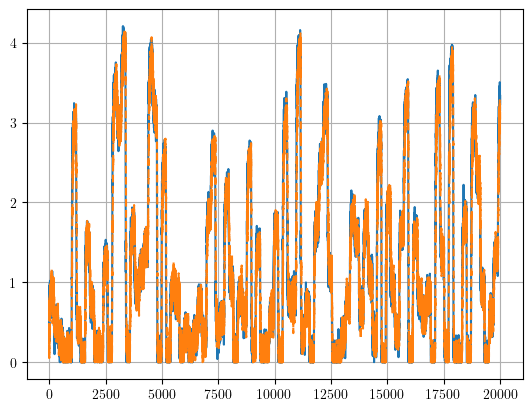

In [5]:
plt.plot(Y_t)

In [6]:
hm = 80
hl = 0
p = 0
q = 0

In [7]:
pipes = {
    "eDMDc w/o $\\sqrt{x}$": Pipeline([
        ("poly", PolynomialFeatures(3, interaction=False)),
        ("hankel", Hankel(hn=hm, step=1)),
        ("dmdc", DMDcRegressor(p=p, q=q)),
    ]),
    "eDMDc w $\\sqrt{x}$": Pipeline([
        (
            "poly",
            ColumnTransformer([
                ("sqrt", FunctionTransformer(np.sqrt), [0]),
                ("poly", PolynomialFeatures(3, interaction=False), [0]),
            ]),
        ),
        ("hankel", Hankel(hn=hm, step=1)),
        ("dmdc", DMDcRegressor(p=p, q=q)),
    ]),
}
models = {name: pipe.fit(U, X).steps[-1][1] for name, pipe in pipes.items()}

In [8]:
Ys_pred = {name: pipe.predict(U) for name, pipe in pipes.items()}

In [9]:
Y_tests_pred = {
    name: pipe.predict(U_t, **{"y0": Y_t[0]}) for name, pipe in pipes.items()
}

In [10]:
stats_ = {}
for name, Y_pred in Y_tests_pred.items():
    stats_[name] = {
        "MAE": mean_absolute_error(Y_t, Y_pred),
        "MAPE": mean_absolute_percentage_error(Y_t, Y_pred),
    }

In [11]:
pd.DataFrame(stats_).round(4)

,eDMDc w/o $\sqrt{x}$,eDMDc w $\sqrt{x}$
MAE,9.240000e-02,9.660000e-02
MAPE,1.892966e+13,1.785557e+13


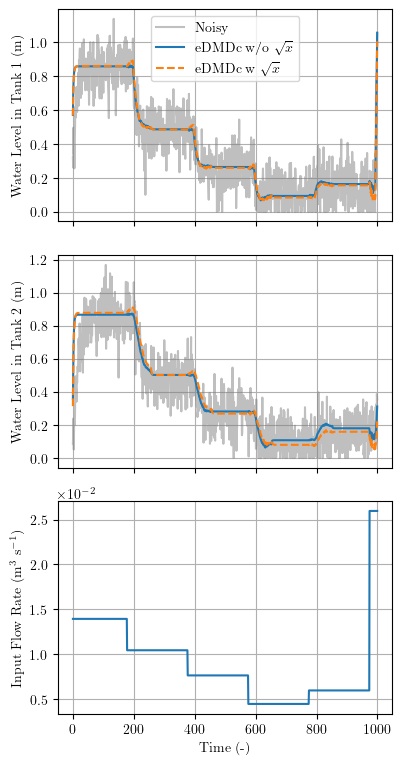

In [12]:
# [donotremove]
fig = plot_results(
    U_t[:part],
    {
        "Noisy": Y_t[:part],
        **{name: Y_pred[:part] for name, Y_pred in Y_tests_pred.items()},
    },
)
fig.savefig(f"{results_path}dmdc_multipred-p{p}-q{q}-hm{hm}-hl{hl}.pdf")

In [13]:
import pickle

with open("data/y_eDMDc.pkl", "wb") as fp:
    pickle.dump(Y_tests_pred, fp)

In [14]:
for name, Y_pred in Y_tests_pred.items():
    np.save(f"results/test_pred_{normalize_string(name)}.npy", Y_pred)
for name, model in models.items():
    np.save(f"results/eig_{normalize_string(name)}.npy", model.eig[0])
    np.save(f"results/amplitudes_{normalize_string(name)}.npy", model.xi)

In [15]:
# [donotremove]
def controllability_test(A, B):
    """
    Test the controllability of a system given state-space matrices A and B.

    Parameters:
    A (ndarray): State matrix of size (n, n)
    B (ndarray): Input matrix of size (n, m)

    Returns:
    bool: True if the system is controllable, False otherwise.
    """
    n = A.shape[0]  # Number of states
    controllability_matrix = B

    # Compute [B, AB, A^2B, ..., A^(n-1)B]
    for i in range(1, n):
        controllability_matrix = np.hstack((
            controllability_matrix,
            np.linalg.matrix_power(A, i) @ B,
        ))

    # Check rank of the controllability matrix
    rank = np.linalg.matrix_rank(controllability_matrix)
    return rank == n


A = model.A
B = model.B

is_controllable = controllability_test(A, B)
print(f"System is controllable: {is_controllable}")


def analyze_controllability(A, B):
    n = A.shape[0]
    controllability_matrix = B
    for i in range(1, n):
        controllability_matrix = np.hstack((
            controllability_matrix,
            np.linalg.matrix_power(A, i) @ B,
        ))

    rank = np.linalg.matrix_rank(controllability_matrix)
    return controllability_matrix, rank


C_matrix, rank = analyze_controllability(A, B)
print("Controllability Matrix:")
print(C_matrix)
print(f"Rank: {rank}/{A.shape[0]}")

System is controllable: True
Controllability Matrix:
[[ 0.46389906 -2.75764354 22.20261718 ... -0.98296048 12.1525099
   0.65412334]
 [-1.43071334 11.48607446  7.84150722 ... -2.43340355 12.19342888
   0.65825553]]
Rank: 2/2
